In [1]:
.L ../libAmBe.so

In [2]:
test // Check if lib is loaded correcly

(const int) 11


In [3]:
char const* path {"../dataset/ambe2022.root"};
DataSetHolder dataset = ambeDataSet(path);

In [4]:
ROOT::RDF::RNode df = filterT1Events(dataset.df, 10e-6)
    .Filter("is_event", "T1 Filter");

In [5]:
df = df.Define("chainMaskT9", "decayChainMask(T9.parentid, T9.trackid, T9.pdg, T9.CreatorProcessID, T9.initialEkin)");
df = createT5Mask(df);
df = df.Redefine(
    "chainMaskT5",
    "ROOT::VecOps::Where(chainMaskT5==maskNOISE && (pdg == 1000020040 || pdg == 1000010030), ROOT::RVec (chainMaskT5.size(), -1), chainMaskT5)"
);

In [6]:
df = df.Filter("ROOT::VecOps::Any(chainMaskT5 == maskGAMMA)", "Gamma reach pvt");

In [7]:
df = df.Filter("ROOT::VecOps::Any(T9.initialEkin[chainMaskT9 == maskCE_ELECT] > 3.7)", "CE produced with Ekin > 4");

In [8]:
ROOT::RDF::RNode df2 = df.Define(
    "volidGamma",
    "volidEpvtTot(volid[chainMaskT5 == maskGAMMA || chainMaskT5 == maskG_CHILD], E_quenched[chainMaskT5 == maskGAMMA || chainMaskT5 == maskG_CHILD])"
);
df2 = df2.Define("edep_pvtG", "std::get<1>(volidGamma)");
df2 = df2.Redefine("volidGamma", "std::get<0>(volidGamma)");

In [9]:
df2 = df2.Filter("ROOT::VecOps::Sum(edep_pvtG > 0.1) == 1", "1 cube CE");

In [10]:
ROOT::RDF::RNode df3 = df2.Redefine("volidGamma", "volidGamma[edep_pvtG > 0.1][0]")
    .Redefine("edep_pvtG", "edep_pvtG[edep_pvtG > 0.1][0]");

In [11]:
df3 = df3.Define("NoiseContrib", "ROOT::VecOps::Sum(E_quenched[volidGamma == volid && !(chainMaskT5 == maskGAMMA || chainMaskT5 == maskG_CHILD)])");

In [12]:
df3.Filter("NoiseContrib").Display({"T5mask", "volid", "E_quenched", "volidCE", "edep_pvtCE", "NoiseContrib"}, 50, 50)->Print()

In [13]:
df3.Mean("edep_pvtG").GetValue() / (df3.Mean("edep_pvtG").GetValue() + df3.Mean("NoiseContrib").GetValue())

(double) 0.36592840


In [14]:
df3 = df3.Define("frac", "edep_pvtG / (edep_pvtG + NoiseContrib)");

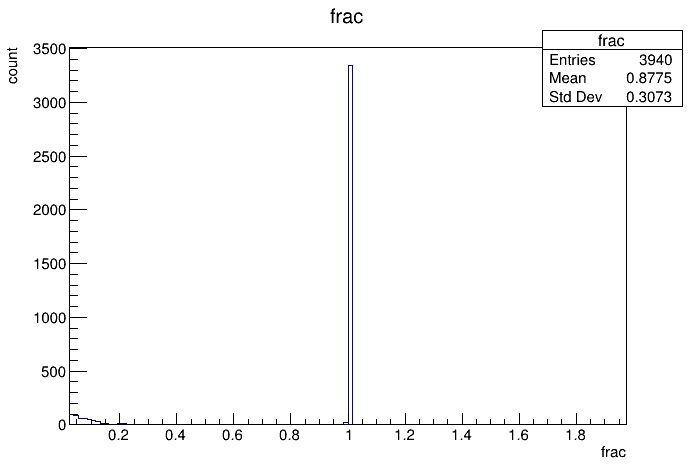

In [15]:
TCanvas c;
auto h = df3.Histo1D( "frac")->DrawClone();
c.Draw();